In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!ls /content/gdrive/My\ Drive/eva-04/S11/* 

We'll need to update our path to import from Drive.

In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/eva-04/S11/')

Now we can import the library and use the function.

In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from albumentations import Compose, RandomCrop, Normalize, HorizontalFlip, Resize
from albumentations.pytorch import ToTensor
from models import ResnetA11 as resnetA11
from transformations import CIFARModel11_Alb as cifar

import importlib
importlib.reload(resnetA11)
importlib.reload(cifar)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = resnetA11.ResNetA11().to(device)

SEED = 1
# CUDA?
print("CUDA Available?", use_cuda)

# For reproducibility
torch.manual_seed(SEED)

if use_cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
#dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if use_cuda else dict(shuffle=True, batch_size=64)

# train dataloader
#train_loader = torch.utils.data.DataLoader(g_train, **dataloader_args)

# test dataloader
#test_loader = torch.utils.data.DataLoader(g_test, **dataloader_args)
#import images as im
#import random
#X,Y,names = im.get_data('cifar-10-batches-py/data_batch_1')
import numpy as np
import matplotlib.pyplot as plt
import os
#importlib.reload(im)
#for x in range(100):
#  im.visualize_image(X,Y,names,random.randint(1,10000),'/content/gdrive/My Drive/eva-04/S9/images')


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
cuda
CUDA Available? True


SHOW PARAMETERS

In [4]:
from utils.global_fun import test_model
from utils.global_fun import train_model
from utils.global_fun import show_summary, run_model_with_entropy,  draw_accuracy_loss_change_graps, plot_accuracy_loss_graphs

import utils.global_fun as fun
from models import ResnetA11 as resnet_a11
from transformations import CIFARModel11_Alb as cifar

import importlib
importlib.reload(resnet_a11)
importlib.reload(cifar)
importlib.reload(fun) 
from torch.optim.lr_scheduler import OneCycleLR
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = OneCycleLR(optimizer, max_lr=0.3, steps_per_epoch=49, epochs=98,last_epoch =-1)
cifar_model = cifar.CIFARModel11_Alb(model,criterion,optimizer,scheduler)
show_summary(cifar_model,input_size=(3,32,32))


Files already downloaded and verified
Files already downloaded and verified
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
         ResBlock-12          [-1, 128, 16, 16]               0
           Conv2d-13       

LRFinder

  pip install torch-lr-finder -v --global-option="amp"


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


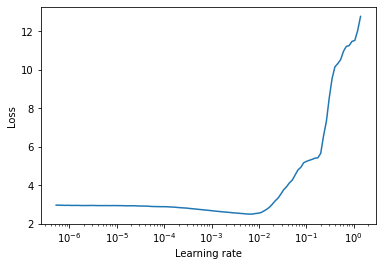

In [5]:
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from lr_finder import LRFinder as lrfinder

#model1 = resnet_a11.ResNetA11().to(device)
#criterion1 = nn.CrossEntropyLoss()

optimizer = optim.SGD(cifar_model.m_model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = lrfinder.LRFinder(cifar_model.m_model, optimizer, criterion, device="cuda")
lr_finder.range_test(cifar_model.m_train_loader, end_lr=100, num_iter=150, step_mode="exp")
#model = rc10.resnet56()
#lr_finder = LRFinder(model,cifar_model.m_optimizer,cifar_model.m_criterion, device)
#lr_finder.range_test(cifar_model.m_trainloader, end_lr=100, num_iter=100, step_mode="exp")
#lr_finder.range_test(cifar_model.m_train_loader, val_loader=cifar_model.m_test_loader, end_lr=100, num_iter=100, step_mode="exp")
lr_finder.plot(skip_end=0)
lr_finder.reset()

DRAW CyclicLR PLOT

In [0]:
import numpy as np
import matplotlib.pyplot as plt

def draw_cyclic_lr_graph(lr_min,lr_max,step,iterations):
  #lr_min,lr_max are in y direction
  # each triangle to be plot with 3 points (0,lr_min),(0+step,lr_max),(2*step,lr_max) 
  x_points = [0]
  y_points = [lr_min]
  last_step=step
  max = True
  plt.figure(figsize=(20,10))
  
  for x in range(iterations):
    x_points.append(last_step)
    last_step= last_step + step
    if(max == True):
      y_points.append(lr_max)
      max = False
    else:
      y_points.append(lr_min)
      max = True
  #for i in range(iterations-1):
    plt.plot(x_points, y_points, 'bo-')
    #print(x_points[i],'::',y_points[i])
  
  plt.xlabel('Iterations')
  plt.ylabel('Lr Range')
  plt.show()


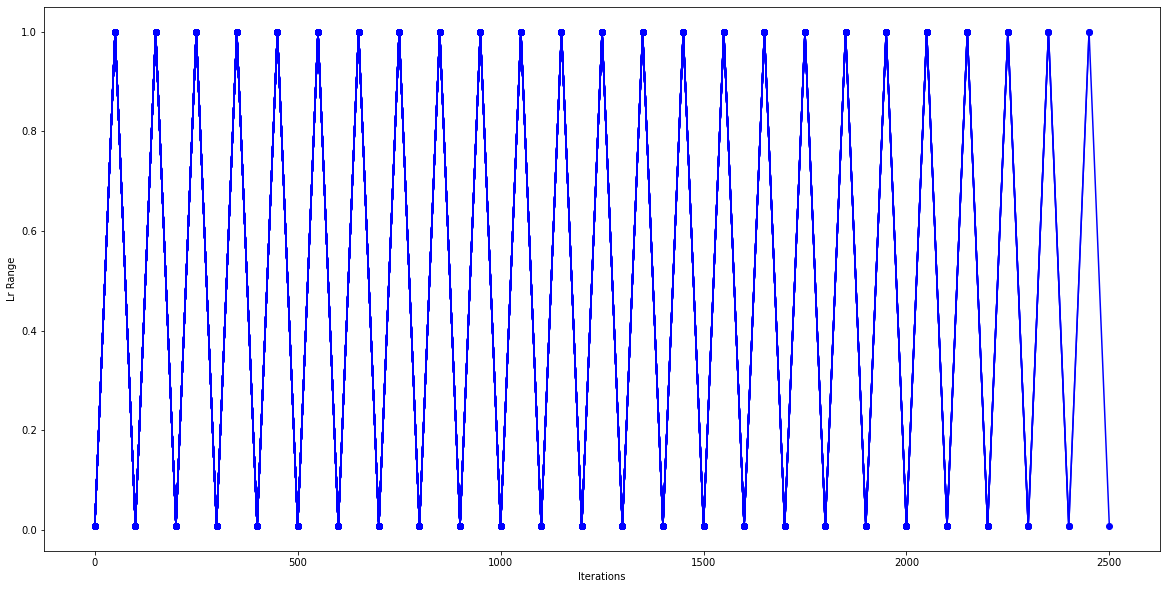

In [9]:
draw_cyclic_lr_graph(0.007,1,50,50)

RUNNING WITH REGULARIZATION

In [10]:
run_model_with_entropy(cifar_model, device, doL1= 1, doL2=1, LAMBDA=0.0005, EPOCHS=30)

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 0
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 0


Loss=2.084268569946289 Batch_id=97 Accuracy=14.06: 100%|██████████| 98/98 [00:30<00:00,  3.16it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 2014/10000 (20.14%)

EPOCH: 1
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 1


Loss=2.091352939605713 Batch_id=97 Accuracy=22.77: 100%|██████████| 98/98 [00:31<00:00,  3.11it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 2762/10000 (27.62%)

EPOCH: 2
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 2


Loss=2.3577966690063477 Batch_id=97 Accuracy=26.30: 100%|██████████| 98/98 [00:31<00:00,  3.14it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 2991/10000 (29.91%)

EPOCH: 3
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 3


Loss=1.9988596439361572 Batch_id=97 Accuracy=29.76: 100%|██████████| 98/98 [00:30<00:00,  3.17it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 3658/10000 (36.58%)

EPOCH: 4
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 4


Loss=1.764593243598938 Batch_id=97 Accuracy=33.75: 100%|██████████| 98/98 [00:30<00:00,  3.18it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 3747/10000 (37.47%)

EPOCH: 5
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 5


Loss=1.773324728012085 Batch_id=97 Accuracy=36.94: 100%|██████████| 98/98 [00:30<00:00,  3.18it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 4426/10000 (44.26%)

EPOCH: 6
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 6


Loss=1.7550337314605713 Batch_id=97 Accuracy=39.92: 100%|██████████| 98/98 [00:31<00:00,  3.16it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 4484/10000 (44.84%)

EPOCH: 7
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 7


Loss=1.6503263711929321 Batch_id=97 Accuracy=42.99: 100%|██████████| 98/98 [00:30<00:00,  3.24it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 4853/10000 (48.53%)

EPOCH: 8
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 8


Loss=1.4525951147079468 Batch_id=97 Accuracy=45.16: 100%|██████████| 98/98 [00:30<00:00,  3.21it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 4887/10000 (48.87%)

EPOCH: 9
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 9


Loss=1.5566011667251587 Batch_id=97 Accuracy=47.17: 100%|██████████| 98/98 [00:30<00:00,  3.22it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 5486/10000 (54.86%)

EPOCH: 10
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 10


Loss=1.433788776397705 Batch_id=97 Accuracy=49.81: 100%|██████████| 98/98 [00:30<00:00,  3.22it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 5802/10000 (58.02%)

EPOCH: 11
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 11


Loss=1.4804092645645142 Batch_id=97 Accuracy=51.37: 100%|██████████| 98/98 [00:30<00:00,  3.25it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 5460/10000 (54.60%)

EPOCH: 12
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 12


Loss=1.264954924583435 Batch_id=97 Accuracy=52.84: 100%|██████████| 98/98 [00:30<00:00,  3.26it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 6153/10000 (61.53%)

EPOCH: 13
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 13


Loss=1.2533880472183228 Batch_id=97 Accuracy=55.10: 100%|██████████| 98/98 [00:30<00:00,  3.24it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 6383/10000 (63.83%)

EPOCH: 14
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 14


Loss=1.2555732727050781 Batch_id=97 Accuracy=57.26: 100%|██████████| 98/98 [00:30<00:00,  3.27it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0020, Accuracy: 6575/10000 (65.75%)

EPOCH: 15
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 15


Loss=1.1369783878326416 Batch_id=97 Accuracy=59.24: 100%|██████████| 98/98 [00:30<00:00,  3.26it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0019, Accuracy: 6602/10000 (66.02%)

EPOCH: 16
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 16


Loss=1.0982805490493774 Batch_id=97 Accuracy=60.41: 100%|██████████| 98/98 [00:30<00:00,  3.23it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0018, Accuracy: 6786/10000 (67.86%)

EPOCH: 17
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 17


Loss=1.0800378322601318 Batch_id=97 Accuracy=61.90: 100%|██████████| 98/98 [00:29<00:00,  3.28it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0018, Accuracy: 6894/10000 (68.94%)

EPOCH: 18
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 18


Loss=1.0930728912353516 Batch_id=97 Accuracy=63.04: 100%|██████████| 98/98 [00:29<00:00,  3.27it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0017, Accuracy: 7157/10000 (71.57%)

EPOCH: 19
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 19


Loss=1.062908411026001 Batch_id=97 Accuracy=63.67: 100%|██████████| 98/98 [00:29<00:00,  3.30it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 7231/10000 (72.31%)

EPOCH: 20
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 20


Loss=1.0501645803451538 Batch_id=97 Accuracy=65.13: 100%|██████████| 98/98 [00:29<00:00,  3.28it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 7322/10000 (73.22%)

EPOCH: 21
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 21


Loss=0.9770160913467407 Batch_id=97 Accuracy=65.85: 100%|██████████| 98/98 [00:29<00:00,  3.28it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 7315/10000 (73.15%)

EPOCH: 22
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 22


Loss=0.9573759436607361 Batch_id=97 Accuracy=66.65: 100%|██████████| 98/98 [00:29<00:00,  3.27it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 7449/10000 (74.49%)

EPOCH: 23
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 23


Loss=0.9031989574432373 Batch_id=97 Accuracy=67.91: 100%|██████████| 98/98 [00:29<00:00,  3.30it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 7422/10000 (74.22%)

EPOCH: 24
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 24


Loss=0.863160252571106 Batch_id=97 Accuracy=68.31: 100%|██████████| 98/98 [00:29<00:00,  3.29it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 7574/10000 (75.74%)

EPOCH: 25
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 25


Loss=0.8604271411895752 Batch_id=97 Accuracy=68.75: 100%|██████████| 98/98 [00:29<00:00,  3.31it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 7481/10000 (74.81%)

EPOCH: 26
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 26


Loss=0.8556681871414185 Batch_id=97 Accuracy=69.53: 100%|██████████| 98/98 [00:29<00:00,  3.27it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 7601/10000 (76.01%)

EPOCH: 27
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 27


Loss=0.8684970140457153 Batch_id=97 Accuracy=70.38: 100%|██████████| 98/98 [00:29<00:00,  3.29it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 7684/10000 (76.84%)

EPOCH: 28
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 28


Loss=0.8188024163246155 Batch_id=97 Accuracy=70.75: 100%|██████████| 98/98 [00:29<00:00,  3.31it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 7778/10000 (77.78%)

EPOCH: 29
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 29


Loss=0.7611013054847717 Batch_id=97 Accuracy=71.47: 100%|██████████| 98/98 [00:29<00:00,  3.27it/s]



Test set: Average loss: 0.0014, Accuracy: 7685/10000 (76.85%)



In [11]:
run_model_with_entropy(cifar_model, device, doL1= 0, doL2=0, LAMBDA=0.0005, EPOCHS=20)

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 0
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 0


Loss=0.7907853126525879 Batch_id=97 Accuracy=72.40: 100%|██████████| 98/98 [00:30<00:00,  3.26it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 7768/10000 (77.68%)

EPOCH: 1
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 1


Loss=0.7392452955245972 Batch_id=97 Accuracy=72.88: 100%|██████████| 98/98 [00:29<00:00,  3.27it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 7846/10000 (78.46%)

EPOCH: 2
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 2


Loss=0.7327612638473511 Batch_id=97 Accuracy=73.01: 100%|██████████| 98/98 [00:29<00:00,  3.27it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 7857/10000 (78.57%)

EPOCH: 3
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 3


Loss=0.7750524878501892 Batch_id=97 Accuracy=73.50: 100%|██████████| 98/98 [00:30<00:00,  3.26it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 7946/10000 (79.46%)

EPOCH: 4
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 4


Loss=0.8550016283988953 Batch_id=97 Accuracy=74.06: 100%|██████████| 98/98 [00:29<00:00,  3.30it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 8059/10000 (80.59%)

EPOCH: 5
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 5


Loss=0.7513861060142517 Batch_id=97 Accuracy=74.75: 100%|██████████| 98/98 [00:29<00:00,  3.30it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8044/10000 (80.44%)

EPOCH: 6
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 6


Loss=0.8463261723518372 Batch_id=97 Accuracy=74.96: 100%|██████████| 98/98 [00:29<00:00,  3.30it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8095/10000 (80.95%)

EPOCH: 7
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 7


Loss=0.6859020590782166 Batch_id=97 Accuracy=75.45: 100%|██████████| 98/98 [00:29<00:00,  3.33it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8180/10000 (81.80%)

EPOCH: 8
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 8


Loss=0.7140284180641174 Batch_id=97 Accuracy=75.57: 100%|██████████| 98/98 [00:29<00:00,  3.33it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8072/10000 (80.72%)

EPOCH: 9
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 9


Loss=0.8143367767333984 Batch_id=97 Accuracy=75.85: 100%|██████████| 98/98 [00:29<00:00,  3.34it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8111/10000 (81.11%)

EPOCH: 10
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 10


Loss=0.6692269444465637 Batch_id=97 Accuracy=76.59: 100%|██████████| 98/98 [00:29<00:00,  3.35it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8220/10000 (82.20%)

EPOCH: 11
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 11


Loss=0.7459731101989746 Batch_id=97 Accuracy=76.79: 100%|██████████| 98/98 [00:29<00:00,  3.31it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8089/10000 (80.89%)

EPOCH: 12
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 12


Loss=0.6510053873062134 Batch_id=97 Accuracy=76.72: 100%|██████████| 98/98 [00:29<00:00,  3.30it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8118/10000 (81.18%)

EPOCH: 13
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 13


Loss=0.6374287605285645 Batch_id=97 Accuracy=77.65: 100%|██████████| 98/98 [00:29<00:00,  3.31it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8200/10000 (82.00%)

EPOCH: 14
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 14


Loss=0.6447204351425171 Batch_id=97 Accuracy=77.79: 100%|██████████| 98/98 [00:29<00:00,  3.35it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8249/10000 (82.49%)

EPOCH: 15
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 15


Loss=0.6067367792129517 Batch_id=97 Accuracy=78.27: 100%|██████████| 98/98 [00:29<00:00,  3.34it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8204/10000 (82.04%)

EPOCH: 16
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 16


Loss=0.7895384430885315 Batch_id=97 Accuracy=78.53: 100%|██████████| 98/98 [00:29<00:00,  3.33it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8287/10000 (82.87%)

EPOCH: 17
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 17


Loss=0.6194934248924255 Batch_id=97 Accuracy=78.86: 100%|██████████| 98/98 [00:29<00:00,  3.34it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8360/10000 (83.60%)

EPOCH: 18
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 18


Loss=0.6046580076217651 Batch_id=97 Accuracy=79.12: 100%|██████████| 98/98 [00:29<00:00,  3.33it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8318/10000 (83.18%)

EPOCH: 19
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 19


Loss=0.6914795637130737 Batch_id=97 Accuracy=79.35: 100%|██████████| 98/98 [00:29<00:00,  3.33it/s]



Test set: Average loss: 0.0009, Accuracy: 8405/10000 (84.05%)



Training and Validation Accuracy Change

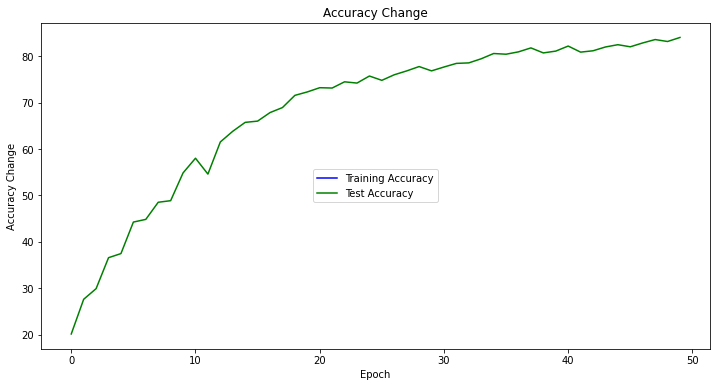

In [14]:

import utils.global_fun as fun
importlib.reload(fun)

importlib.reload(fun)
from utils.global_fun import plot_accuracy_loss_graphs, draw_accuracy_graph

draw_accuracy_graph(cifar_model,'Accuracy Change')

SAVE MODEL

In [0]:
state = {
    'epoch': 150,
    'state_dict': cifar_model.m_model.state_dict(),
    'optimizer': cifar_model.m_optimizer.state_dict()
}

filepath = "/content/gdrive/My Drive/eva-04/S11/saved_model"

torch.save(cifar_model.m_model.state_dict(), open(os.path.join(filepath, 'model.pt'), 'wb'))
torch.save(cifar_model.m_optimizer.state_dict(), open(os.path.join(filepath, 'optimizer.pt'), 'wb'))
torch.save(state, open(os.path.join(filepath, 'savedmodel'), 'wb'))

#model.load_state_dict(state['state_dict'])
#optimizer.load_state_dict(state['optimizer'])
#model = torch.load(filepath)


LR FINDER

Increases the learning rate in an exponential manner and computes the training loss for each learning rate. lr_finder.plot() plots the training loss versus logarithmic learning rate.

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


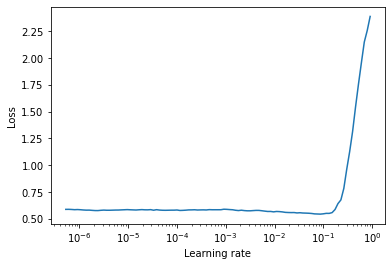

In [15]:
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from lr_finder import LRFinder as lrfinder

model = resnet_a11.ResNetA11().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(cifar_model.m_model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = lrfinder.LRFinder(cifar_model.m_model, optimizer, criterion, device="cuda")
lr_finder.range_test(cifar_model.m_train_loader, end_lr=100, num_iter=150, step_mode="exp")
lr_finder.plot()

lr_finder.reset()

#model = rc10.resnet56()
#lr_finder = LRFinder(model,cifar_model.m_optimizer,cifar_model.m_criterion, device)
#lr_finder.range_test(cifar_model.m_trainloader, end_lr=100, num_iter=100, step_mode="exp")


GRADCAM VISUALIZATION

In [0]:

def plot_gradcam(cam_data, pred_data, classes, plot_name):
    fig, axs = plt.subplots(len(cam_data), 2, figsize=(8, 50))

    for idx in range(len(cam_data)):
        label = classes[pred_data[idx]['label']]
        prediction = classes[pred_data[idx]['prediction']]

        axs[idx][0].axis('off')
        axs[idx][0].set_title(f'Image: {idx + 1}\nLabel: {label}')
        axs[idx][0].imshow(cam_data[idx]['image'])

        axs[idx][1].axis('off')
        axs[idx][1].set_title(f'GradCAM: {idx + 1}\nPrediction: {prediction}')
        axs[idx][1].imshow(cam_data[idx]['result']['layer3'])
    fig.tight_layout()
    fig.subplots_adjust(top=1.1)

Mode set to GradCAM.


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


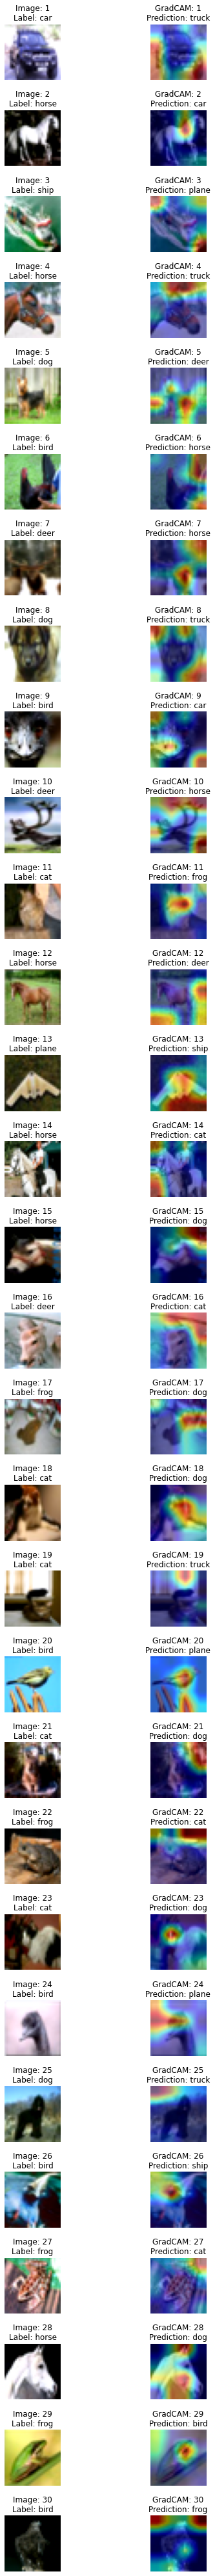

In [21]:

layers = ['layer3']
grad_cam = vs.GradCAMView(
    cifar_model.m_model, layers,
    device, cifar.mean(), cifar.std()
)

from gradcam import visualize as vs 
importlib.reload(vs)

views = grad_cam([x['image'] for x in cifar_model.m_incorrect_samples])
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
plot_gradcam(views, cifar_model.m_incorrect_samples, classes, 'prediction_gradcam.png')